# Dropping a ball
Written by Tim Atherton for Computational Physics 
January 16, 2020

This program aims to simulate the motion of a ball dropped from an initial height of $y0$ under gravity $g$ using the Euler discretization.

## Import libraries for plotting and numerical work

In [6]:
import sys
print(sys.version)

3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:01:53) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Set up general parameters for the calculation
- Gravitational acceleration constant: $10 \frac{m}{s^2}$

- Initial height: $y_0$ in $m$
- Initial velocity: $v_0$ in $\frac{m}{s}$
- Initial time: $t_0$ in $s$
- Time resolution: $dt$ in $0.1s$
- Total simulation time: $t_f$ in $s$

In [37]:
g = 10 ; y0 = 0 ; v0 = 0 ; t0 = 0 ; dt = 0.1 ; tf = 100 

## Set number of steps to take in the trajectory calculation

In [38]:
nsteps = int(tf/dt)+1

## Set the properties of the ball under investigations
- The properties $S_b$ of the individual balls is a collection of elements pertaining to the various physical properties of the ball in the test set.
- Property list:
    - Ball mass: $m$ in grams
    - Ball diameter: $d$ in mm
    - Ball radius: $r$ in mm
    - Ball surface area: $s_a = 4\pi r^2$ in mm$^2$ 
    - Ball material: $b_{mat}:$ $\{$'plastic':0, 'rubber':1, 'foam':2$\}$
    - Porosity: $p:$ $\{ 0.0, ..., 1.0 \}$
- Red Foam Ball
    - $S_r:$ $\{$ $m:$ 0.40,  $d:$ (29, 33), $r:$ (14.5, 16.5), $s_a:$ 3019.07, $b_{mat}:$, $p:$, $\}$
    - Note: The surface area of the red ball is computed using $r = \frac{1}{2}r_1r_2$
- Black Rubber Ball
    - $S_b:$ $\{$ $m:$ 24.55, $d:$ 39.8, $r:$ 19.9, $s_a:$ 4976.4, $b_{mat}:$, $p:$, $\}$
- White Plastic Ball
    - $S_w:$ $\{$ $m:$ 2.80, $d:$ 40.2, $r:$ 20.1, $s_a:$ 5076.94, $b_{mat}:$, $p:$, $\}$

In [39]:
S = {'color': 'black', 'm': 24.55, 'd': 0.0, 'r': 19.9, 's_a': 4976.4, 'b_mat': None, 'p': 0.0}

## Create arrays for time, velocity and position

In [40]:
t = np.linspace(t0,tf,nsteps)
v = np.zeros([nsteps])
y = np.zeros([nsteps])

### Drag Equation Documentation
[Link](https://www.nuclear-power.net/nuclear-engineering/fluid-dynamics/what-is-drag-air-and-fluid-resistance/drag-force-drag-equation/)

In [41]:
# drag_accel
# Parameters: coefficient of drag, surface area of object, velocity of object, mass of object
# Units: m = grams, area = mm^2, velocity = m/s, coefficient = unitless
# Calculates the drag acceleration of an object with the given properties
def drag_accel(coefficient, area, flow_v, m):
    return (coefficient * (area * 0.000001) * ((1.225 * (flow_v**2))/2)) / (m * 0.001)

In [42]:
# TODO: Compute the drag coefficient based on the ball properties (material / porosity)

## Main loop, where we successively update velocity and time according to the Euler rule

In [43]:
y[0] = y0; v[0] = v0

for i in range(1, nsteps):
    v[i] = v[i-1] + (dt**2 * (-g + drag_accel(0.47, S['s_a'], v[i-1], S['m'])))
    y[i] = y[i-1] + v[i] * dt

## Visualize the result

Text(0, 0.5, 'Height /m')

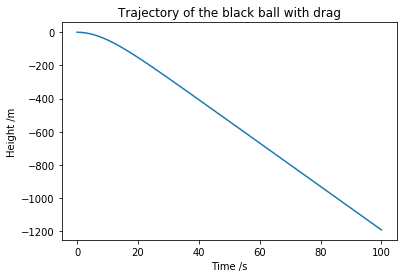

In [44]:
%matplotlib inline
plt.plot(t,y)
plt.title('Trajectory of the {} ball with drag'.format(S['color']))
plt.xlabel('Time /s')
plt.ylabel('Height /m')

Text(0, 0.5, 'Velocity [m/s]')

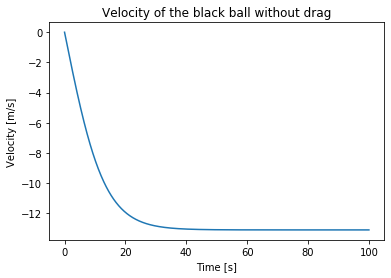

In [45]:
%matplotlib inline
plt.plot(t,v)
plt.title('Velocity of the {} ball without drag'.format(S['color']))
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')